# Titanic - Machine Learning from disaster

In [1]:
# Import des modules pour analyse

# Manipulation de donnée
import pandas as pd
import numpy as np

# Visualisation de donnée
import matplotlib.pyplot as plt

# Import des modules d'analyses
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Ajout des dataframe

train_data = pd.read_csv('train.csv')

test_data = pd.read_csv('test.csv')

In [3]:
# Création d'une liste des dataframes pour automatiser le nettoyage
list_df = [train_data, test_data]

In [4]:
train_data['Age'] = train_data.groupby('Pclass')['Age'].transform(
    lambda x: x.fillna(x.median())
)

train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Suppression des variables non significatif (vue dans un autre projet)

train_data = train_data.drop(['Name', 'Cabin', 'Age', 'Ticket', 'SibSp'], axis = 1)

In [7]:
# Encodage des variables catégorielles

train_data = pd.get_dummies(train_data, columns=['Sex','Embarked'], drop_first = True)

## Création du modèle de classification

In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,0,7.2500,True,False,True
1,2,1,1,0,71.2833,False,False,False
2,3,1,3,0,7.9250,False,False,True
3,4,1,1,0,53.1000,False,False,True
4,5,0,3,0,8.0500,True,False,True


In [9]:
# Séparation X et y
X = train_data[['Pclass', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']]

y = train_data['Survived']

# Création en valeur train et test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Standardisation des valeurs x
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

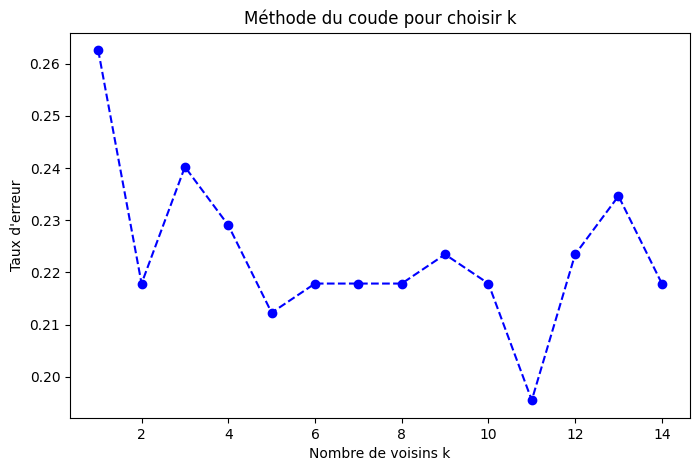

In [10]:
# Test de différents KNN

k_values = range(1,15)
errors = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred)  # Erreur = 1 - Précision
    errors.append(error)

# Tracer la courbe d'erreur en fonction de k
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker='o', linestyle='dashed', color='b')
plt.xlabel("Nombre de voisins k")
plt.ylabel("Taux d'erreur")
plt.title("Méthode du coude pour choisir k")
plt.show()

Comme on le voit sur le graphique le nombre de voisin qui propose le moins d'erreur est le 11. 

In [11]:
best_k = k_values[np.argmin(errors)]
print(f"Le meilleur k est : {best_k}")

Le meilleur k est : 11


In [12]:
# Création du modèle finale
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

# Précision du modèle
y_pred = knn_final.predict(X_test)
accuracy = knn_final.score(X_test, y_test)
print(f"Accuracy finale: {accuracy:.4f}")

Accuracy finale: 0.8045


## Classification Survivant sur la df test

In [13]:
# Création d'une copie de la dataframe test
test_data_original = test_data.copy()


# Suppression de PassengerId SEULEMENT de la copie pour le modèle
test_data = test_data.drop('PassengerId', axis=1)

In [14]:
# Nettoyage de la variable test
test_data = test_data.drop(['Name', 'Cabin', 'Age', 'Ticket', 'SibSp'], axis = 1)

test_data = pd.get_dummies(test_data, columns=['Sex','Embarked'], drop_first = True)

In [16]:
test_data.fillna(test_data['Fare'].mean(), inplace=True)

In [17]:
test_data_scaled = scaler.transform(test_data)
prediction = knn_final.predict(test_data_scaled)

In [18]:
# Ajouter les prédictions à la dataframe ORIGINALE qui a PassengerId
test_data_original['Survived'] = prediction

# Vous avez maintenant votre fichier avec PassengerId et les prédictions
print(test_data_original[['PassengerId', 'Survived']].head())

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1


In [21]:
submission = test_data_original[['PassengerId', 'Survived']]

In [24]:
submission.to_csv('submission.csv', index = False)